In [12]:
import numpy as np
import h5py
%matplotlib inline
from IPython.display import Image

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 'x-large',
         'xtick.labelsize': 'large',
         'ytick.labelsize': 'large'}
pylab.rcParams.update(params)

from astropy.visualization import make_lupton_rgb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
tag = 'gri'
imarr_fn = '../data/images_h5/images_{}.h5'.format(tag)
results_fn = '../results/results_{}.h5'.format(tag)

In [68]:
plot_dir = '../papers/images'

In [4]:
imarr = h5py.File(imarr_fn, 'r')
res = h5py.File(results_fn, 'r')
print(imarr.keys())
print(res.keys())

<KeysViewHDF5 ['idxs', 'images', 'object_ids']>
<KeysViewHDF5 ['anomaly_scores', 'disc_scores', 'gen_scores', 'idxs', 'object_ids', 'reconstructed']>


In [6]:
print(len(imarr['idxs']))

942782


In [7]:
idx2imloc = {}
for i in range(len(imarr['idxs'])):
    if i%100000==0: 
        print(i)
    idx2imloc[imarr['idxs'][i]] = i

0
100000
200000
300000
400000
500000
600000
700000
800000
900000


In [8]:
idx2resloc = {}
for i in range(len(res['idxs'])):
    idx2resloc[res['idxs'][i]] = i

In [10]:
def luptonize(x, rgb_q=15, rgb_stretch=0.5, rgb_min=0):
    if x.ndim==3:
        x = make_lupton_rgb(x[:,:,2], x[:,:,1], x[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
    elif x.ndim==4:
        x = np.array([make_lupton_rgb(xi[:,:,2], xi[:,:,1], xi[:,:,0],
                      Q=rgb_q, stretch=rgb_stretch, minimum=rgb_min)
                      for xi in x])
    else:
        raise ValueError(f"Wrong number of dimensions! Gave {x.ndim}, need 3 or 4")
    return x

In [65]:
def plot_ims(ids, nrows, ncols, saveto=None):
    assert len(ids)<=nrows*ncols, "bad rows/cols for number of ids!"
    fig, axarr = plt.subplots(nrows,ncols,figsize=(4,4))
    plt.subplots_adjust(hspace=0.2, wspace=0.05)

    count = 0
    for i in range(nrows):
        for j in range(ncols):
            idx = ids[count]
            loc = idx2imloc[idx]
            im = imarr['images'][loc]
            obj_id = int(imarr['object_ids'][loc])
            ax = axarr[i][j]
            ax.set_title(obj_id, fontsize=9)
            ax.imshow(luptonize(im))
            ax.set_xticks([])
            ax.set_yticks([])
            count += 1
            
            if count>=len(ids):
                break
                
    if saveto:
        plt.savefig(saveto)

In [66]:
bluecore_ids = [935055, 936569, 936288, 782291]
sf_ids = [461525, 702705, 402208, 549909]
tidal_ids = [406992,105162,232476,402855] #936581

FileNotFoundError: [Errno 2] No such file or directory: '../papers/images/anomalies_bluecore.png'

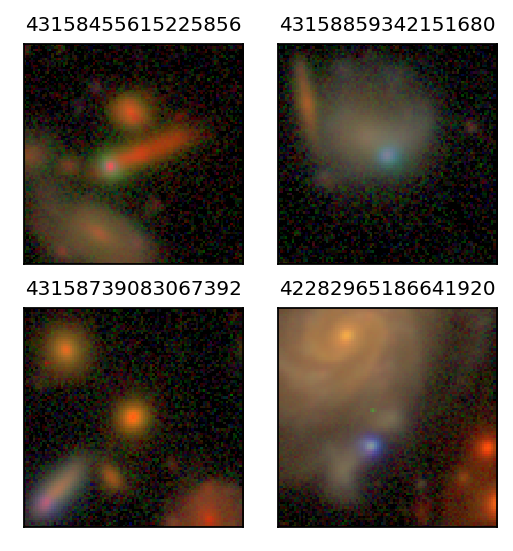

In [69]:
plot_ims(bluecore_ids, 2, 2, saveto=f'{plot_dir}/anomalies_bluecore.png')

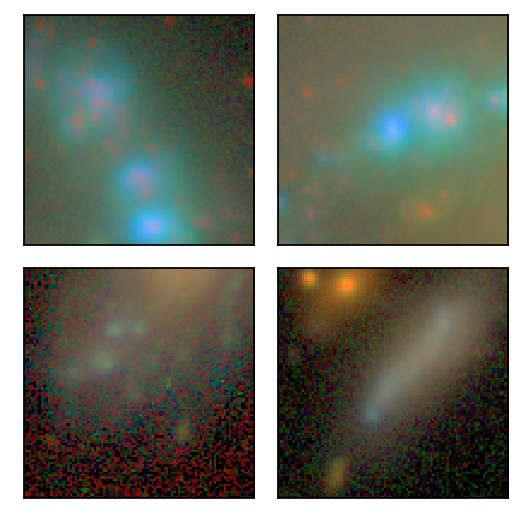

In [45]:
plot_ims(sf_ids, 2, 2)

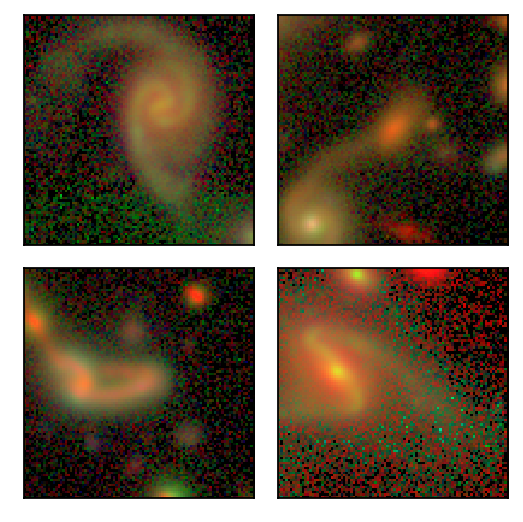

In [47]:
plot_ims(tidal_ids, 2, 2)